# <b><u> Extraction/identification of major topics & themes discussed in news articles. </u></b>

### The task is to identify major themes/topics across a collection of BBC news articles.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
!pip install autocorrect
!pip install pyLDAvis

     |████████████████████████████████| 622 kB 5.1 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=d3a585a40784d6f03d028c7b6a431afd147f21cdb29a16a646770f41cdf273a5
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e9a2472e6af86763bbc5b8d36580ffce867e5086b4459c8703cf2c37ea2c85d8
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


First we have to develop our own dataset for our dataset, we will read all the downloaded articles into one list corpus. We will use the folder name as a list of labels.Then we can covert them into dataframe

In [ ]:
# %cp -r '/content/drive/MyDrive/bbc' /content/

In [6]:
News=[]
Type=[]

path = '/content/bbc'
folders = ["business", "entertainment", "politics", "sport", "tech"] 

for i in folders:
    files=os.listdir(path + '/' + i)
    for text_file in files:
        file_path = path + '/' + i + '/' + text_file
        with open(file_path, 'rb') as f:
            data = f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News, 'type':Type}
df = pd.DataFrame(data)

Sample data

In [7]:
df.head()

,news,type
0,b'China continues breakneck growth\n\nChina\'s...,business
1,b'US interest rates increased to 2%\n\nUS inte...,business
2,b'Ukraine trims privatisation check\n\nUkraine...,business
3,b'Bargain calls widen Softbank loss\n\nJapanes...,business
4,b'US data sparks inflation worries\n\nWholesal...,business


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [9]:
# removing duplicate observations
df=df.drop_duplicates()

In [10]:
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

Convert object type to str

In [11]:
# Converting column into string
df['news'] = df['news'].astype('str') 

In [12]:
# Removing HTML Tag
import re
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [13]:
df['news']=df['news'].apply(remove_html_tags)

In [14]:
# Removing URLs
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [15]:
df['news']=df['news'].apply(remove_urls)

In [16]:
# Removing numbers
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [17]:
df['news']=df['news'].apply(remove_numbers)

In [18]:
# Removing single Charecter
def remove_single_char(text):
	single_char_pattern = r'\s+[a-zA-Z]\s+'
	without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
	return without_sc

In [19]:
df['news']=df['news'].apply(remove_single_char)

In [20]:
stop_list=list(stopwords.words('english'))

In [21]:
# Removing StopWord
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stop_list]
  return ' '.join(main_text)

In [22]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [23]:
df['news']=df['news'].apply(Change_text)

In [24]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

## Exploratory Data Analysis

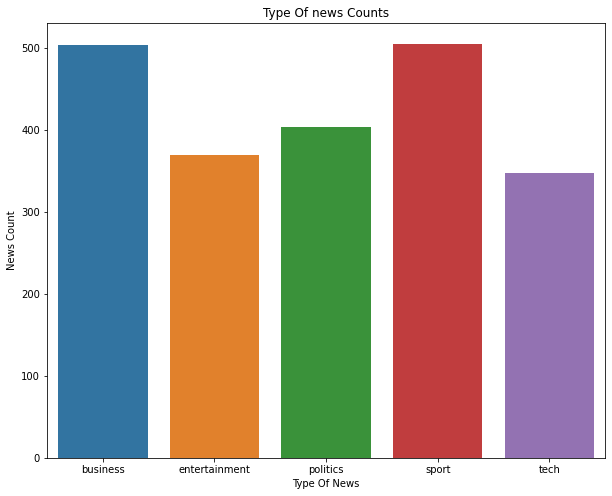

In [25]:
import warnings 
plt.figure(figsize=(10,8))
warnings.filterwarnings("ignore")
sns.countplot(df['type'], data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [26]:
df['length']=df['news'].apply(len)
df.head()

,news,type,length
0,continue breakneck growthnnchina economy expan...,business,1205
1,bus interest rate increase interest rate rise ...,business,1633
2,trim privatisation checknnukraine state asset ...,business,1317
3,call widen lossnnjapanese communication firm w...,business,547
4,spark inflation worriesnnwholesale price rise ...,business,1303


In [27]:
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,length,word_count
0,continue breakneck growthnnchina economy expan...,business,1205,175
1,bus interest rate increase interest rate rise ...,business,1633,243
2,trim privatisation checknnukraine state asset ...,business,1317,184
3,call widen lossnnjapanese communication firm w...,business,547,81
4,spark inflation worriesnnwholesale price rise ...,business,1303,186


In [28]:
bbc_business = df[df['type'] == 'business']
bbc_entertainment = df[df['type'] == 'entertainment']
bbc_politics = df[df['type'] == 'politics']
bbc_sport = df[df['type'] == 'sport']
bbc_tech = df[df['type'] == 'tech']

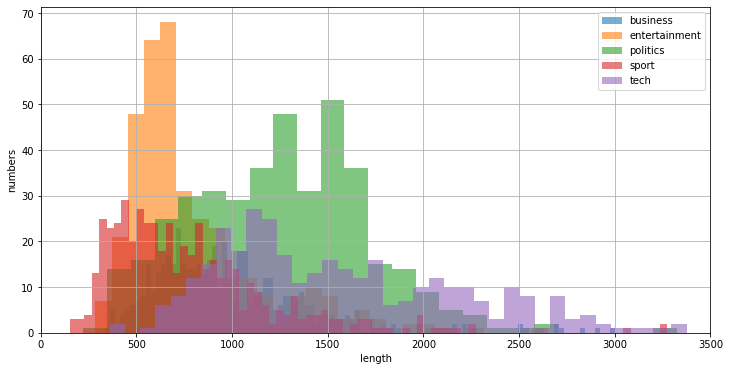

In [29]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

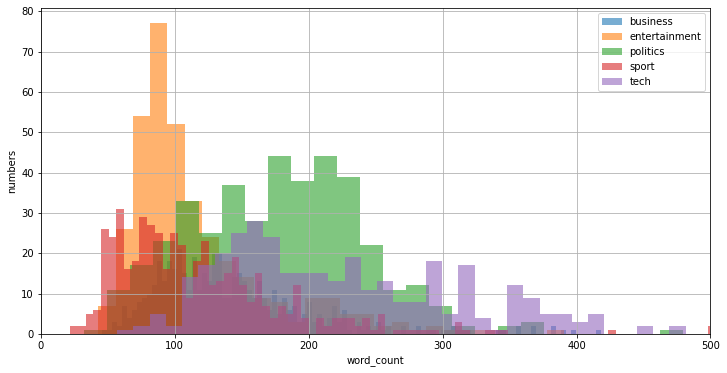

In [30]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

First we develop a list of the top words used across all headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [31]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

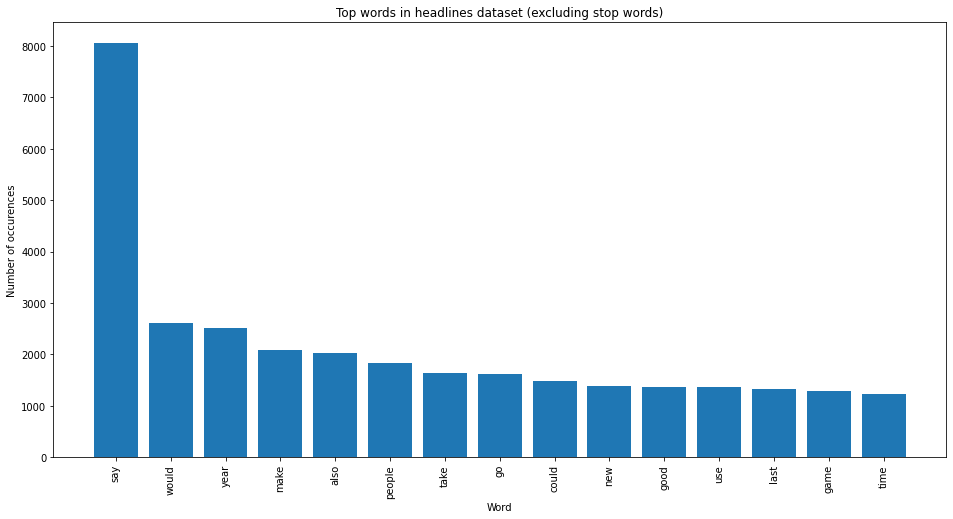

In [32]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

We can see that our top word are in our dataset are year,make

Word Cloud for Topic Business

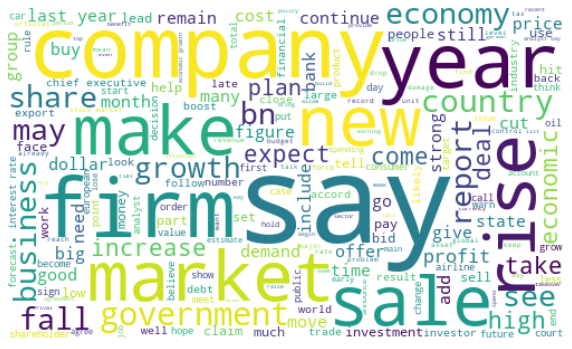

In [33]:
plt.figure(figsize=(10,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

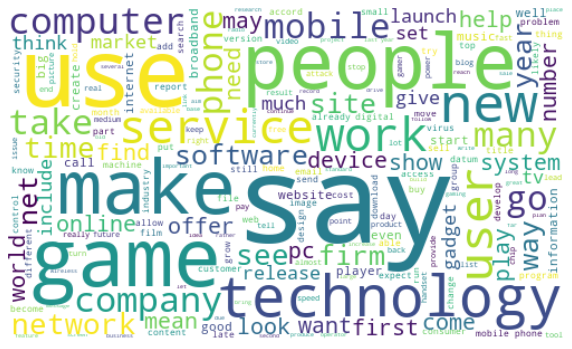

In [34]:
plt.figure(figsize=(10,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

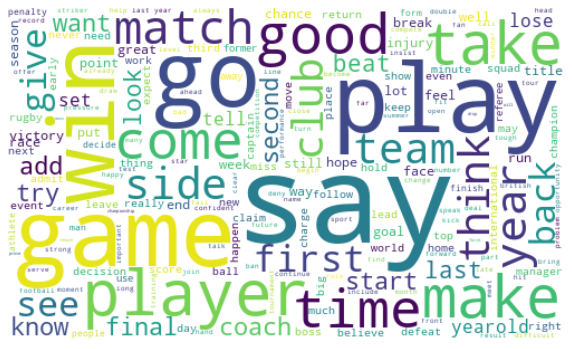

In [35]:
plt.figure(figsize=(10,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

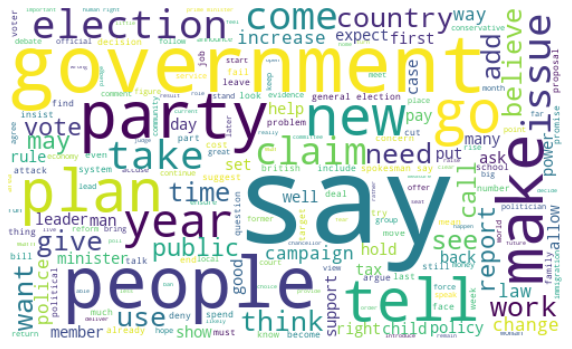

In [36]:
plt.figure(figsize=(10,10))
allWords = ' '.join([topic for topic in df[df['type']=='politics']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Topic Modelling

We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of BBC News using TF-IDF Vectorizer with unigram

In [37]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)
matrix=vectorizer.fit_transform(df['news'])
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [38]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,...,win,winner,work,world,would,write,year,yearold,yet,young
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.057544,0.0,...,0.0,0.0,0.000000,0.062691,0.000000,0.0,0.120156,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.051066,0.0,0.030724,0.0,...,0.0,0.0,0.031897,0.033472,0.045159,0.0,0.021385,0.0,0.0,0.0
2,0.0,0.0,0.0,0.081084,0.000000,0.0,0.000000,0.0,0.059287,0.0,...,0.0,0.0,0.000000,0.000000,0.087142,0.0,0.082530,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.072150,0.0,0.068332,0.0,0.0,0.0
4,0.0,0.0,0.0,0.063831,0.079241,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.034300,0.0,0.064969,0.0,0.0,0.0


### Latent Semantic Analysis

In [39]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

In [40]:
lsa_doc = pd.DataFrame(lsa_model.transform(matrix))

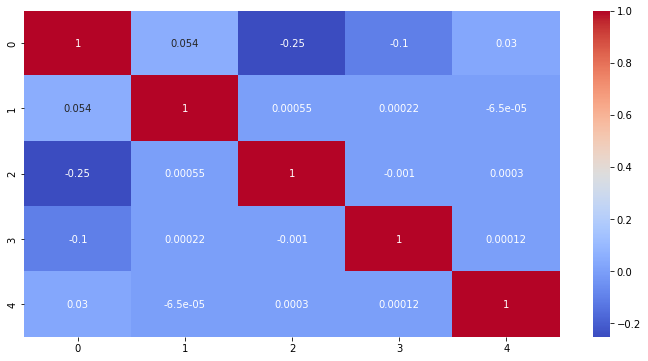

In [41]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [42]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [43]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

Obtain the most frequent words in each topic 

In [44]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0], end=" ")
    print()

Topic 0: 
would year make game also people go 
Topic 1: 
game play film win good player match 
Topic 2: 
film award star director good include movie 
Topic 3: 
sale rise price market game growth fall 
Topic 4: 
phone use mobile technology user game people 


In [45]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(5):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [46]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.009s...
[t-SNE] Computed neighbors for 2127 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.057029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.327736
[t-SNE] KL divergence after 2000 iterations: 0.845347


In [47]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:5]

In [48]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(5):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [49]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, matrix, vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(5):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

### Latent Dirichilet Allocation

In [50]:
word_data = df['news'].str.split().tolist()

In [51]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [52]:
doc = pd.DataFrame(model.transform(matrix))

In [53]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

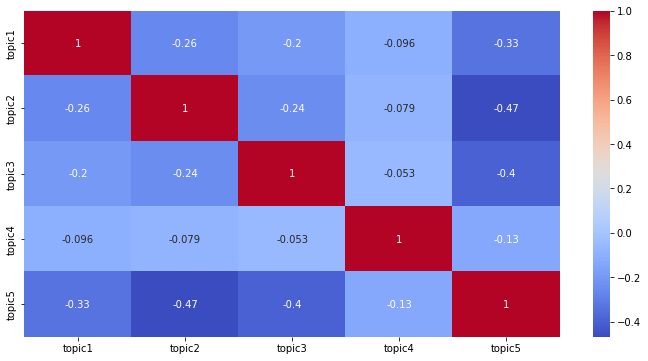

In [54]:
sns.heatmap(data=doc.corr(),annot=True,cmap='coolwarm')

In [55]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [56]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.003s...
[t-SNE] Computed neighbors for 2127 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.003780
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.781574
[t-SNE] KL divergence after 2000 iterations: 0.221999


In [57]:
top_3_words_lda = get_top_n_words(3, lda_keys, matrix,vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(5):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [58]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [59]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  32.269975
1       51.163364 -159.968018       2        1  25.958558
2      -73.144554   21.523815       3        1  18.862771
0      -66.410133 -110.606438       4        1  17.163328
3       54.417324   12.443444       5        1   5.745367, topic_info=         Term       Freq       Total Category  logprob  loglift
84    company  62.000000   62.000000  Default  30.0000  30.0000
163      firm  61.000000   61.000000  Default  29.0000  29.0000
46        bid  26.000000   26.000000  Default  28.0000  28.0000
80       club  35.000000   35.000000  Default  27.0000  27.0000
98      court  27.000000   27.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
146      face   5.481351   36.433089   Topic5  -4.8948   0.9627
387      sale   4.913604   49.545729   Topic5  -5.0041   0.5459
58   business   4.317591   32.258790   Topic5  -5.1335   0.8457
480     would   4.667614  100.251770   Topic5  -5.0555  -0.2103
402     share   4.359954   39.887247   Topic5  -5.1237   0.6432

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         2  0.226701   access
2         3  0.113350   access
2         4  0.623427   access
4         1  0.052141  account
4         2  0.156422  account
...     ...       ...      ...
482       4  0.111618     year
482       5  0.030441     year
483       1  0.833876  yearold
483       2  0.108766  yearold
483       5  0.036255  yearold

[728 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4])

This is a much better result! Controlling for t -SNE, it would seem that LDA has had much more succcess than LSA and LDA(Genisim) in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we Use bigram for our data.

### Latent Dirichilet Allocation using bigram 

In [60]:
bivectorizer = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(2,2))
bigram_vectorized = bivectorizer.fit_transform(df['news'])
df2= pd.DataFrame(bigram_vectorized.todense() , columns=bivectorizer.get_feature_names())

In [61]:
df2.head()

,accord analyst,accord figure,accord report,accord research,action take,actor award,add government,add say,add think,add would,...,year take,year tell,year think,year time,year top,year work,year would,year year,young people,young player
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
bi_lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [63]:
doc = pd.DataFrame(bi_lda.transform(bigram_vectorized))

In [64]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

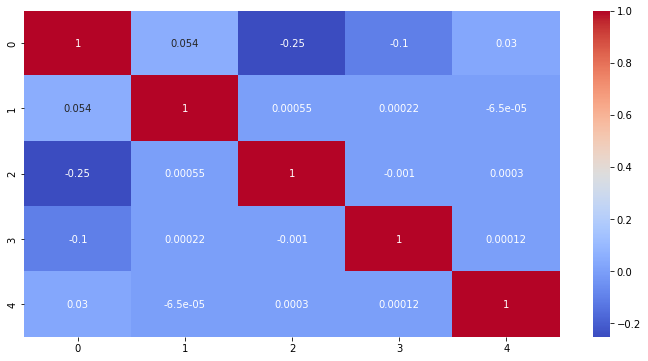

In [65]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [66]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [67]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  23.763575
1       51.163364 -159.968018       2        1  23.647478
3      -73.144554   21.523815       3        1  20.019078
0      -66.410133 -110.606438       4        1  18.650448
4       54.417324   12.443444       5        1  13.919420, topic_info=                 Term        Freq       Total Category  logprob  loglift
577      mobile phone  210.000000  210.000000  Default  30.0000  30.0000
933         say would  273.000000  273.000000  Default  29.0000  29.0000
330  general election  114.000000  114.000000  Default  28.0000  28.0000
446     interest rate   87.000000   87.000000  Default  27.0000  27.0000
123   chief executive  143.000000  143.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
681        people use   32.508890   63.990640   Topic5  -4.7149   1.2947
54        analyst say   33.299058   67.089161   Topic5  -4.6909   1.2714
837        say expect   25.594916   43.036401   Topic5  -4.9540   1.4522
472         last year   58.191159  430.901969   Topic5  -4.1327  -0.0303
940       second half   20.324079   37.956174   Topic5  -5.1846   1.3473

[277 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         1  0.953744  accord report
18        5  0.944721  also announce
41        1  0.320204       also say
41        2  0.547445       also say
41        4  0.020658       also say
...     ...       ...            ...
1237      4  0.927226     year would
1239      1  0.144824   young people
1239      2  0.703430   young people
1239      3  0.020689   young people
1239      4  0.124135   young people

[384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

### Word2vec

In [68]:
from gensim.models import Word2Vec
word2vec = Word2Vec(word_data, min_count=2)

In [69]:
vocabulary = word2vec.wv.vocab

In [70]:
similar_words = word2vec.wv.most_similar('tax')
for x in similar_words:
  print(x)

('cut', 0.9954869747161865)
('income', 0.9904657602310181)
('spending', 0.989708662033081)
('taxis', 0.9888707399368286)
('premium', 0.9869095087051392)
('pay', 0.9848912954330444)
('consumer', 0.9840928316116333)
('council', 0.9827802181243896)
('interest', 0.982415497303009)
('oil', 0.9816327095031738)


/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


In [71]:
word = pd.DataFrame(similar_words)
word.head()

,0,1
0,cut,0.995487
1,income,0.990466
2,spending,0.989709
3,taxis,0.988871
4,premium,0.986910
